In [1]:
import numpy
import time
import wendy
%pylab inline
import matplotlib.animation as animation
from matplotlib import cm
from IPython.display import HTML
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': False,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
_SAVE_GIFS= True
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


# Scaling of ``wendy`` with particle number *N*

We will investigate how ``wendy`` scales with the number $N$ of particles using a self-gravitating disk. The following function initializes a self-gravitating disk:

In [2]:
def initialize_selfgravitating_disk(N):
    totmass= 1.
    sigma= 1.
    zh= sigma**2./totmass # twopiG = 1. in our units
    tdyn= zh/sigma
    x= numpy.arctanh(2.*numpy.random.uniform(size=N)-1)*zh*2.
    v= numpy.random.normal(size=N)*sigma
    v-= numpy.mean(v)
    m= numpy.ones_like(x)/N
    return (x,v,m,tdyn)

## Time/collision for exact solver

We believe that this should go as $\log(N)$:

In [3]:
Ns= numpy.round(10.**numpy.linspace(1.,5.,11)).astype('int')
ntrials= 3
T= numpy.empty((len(Ns),ntrials))
ncoll= numpy.empty((len(Ns),ntrials))
tdyn_fac_norm= 3000
for ii,N in enumerate(Ns):
    for jj in range(ntrials):
        x,v,m,tdyn= initialize_selfgravitating_disk(N)
        g= wendy.nbody(x,v,m,tdyn*(tdyn_fac_norm/N)**2.,maxcoll=10000000,full_output=True)
        tx,tv,tncoll, time_elapsed= next(g)
        if tncoll > 0:
            T[ii,jj]= time_elapsed / tncoll
            ncoll[ii,jj]= tncoll*(N/tdyn_fac_norm)**2.
        else:
            T[ii,jj]= numpy.nan
            ncoll[ii,jj]= numpy.nan

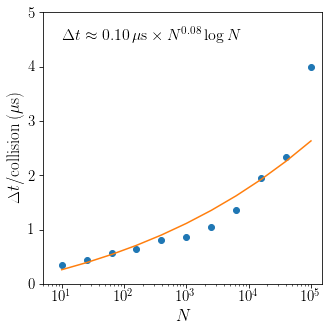

In [4]:
plot(Ns,numpy.nanmean(T,axis=1)*10.**6,'o')
p= numpy.polyfit(numpy.log(Ns),numpy.log(numpy.nanmean(T,axis=1)*10.**6/numpy.log(Ns)),deg=1)
plot(Ns,numpy.exp(numpy.polyval(p,numpy.log(Ns)))*numpy.log(Ns))
pyplot.text(10,4.5,r'$\Delta t  \approx %.2f\,\mu\mathrm{s} \times N^{%.2f}\log N$' % (numpy.exp(p[1]),p[0]),size=16.)
gca().set_xscale('log')
xlim(5,150000)
ylim(0.,5.)
xlabel(r'$N$')
ylabel(r'$\Delta t / \mathrm{collision}\,(\mu\mathrm{s})$')

The behavior seems to be more like $(\log N)^2$ or $N^{1/4}$, probably because the implementation of the binary search tree to determine the next collision is not optimal.

## Number of collisions per dynamical time

In a dynamical time, every particle will cross every other particle, so the total number of collisions per dynamical time should scale as $N^2$, which is indeed what we observe:

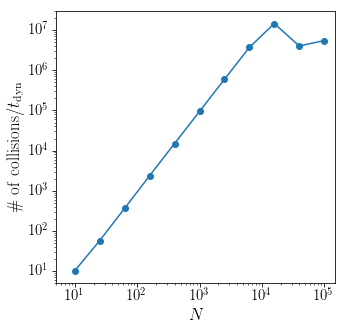

In [5]:
plot(Ns,numpy.nanmean(ncoll,axis=1),'o-')
gca().set_xscale('log')
gca().set_yscale('log')
xlim(5,150000)
#ylim(0.,2.)
xlabel(r'$N$')
ylabel(r'$\#\ \mathrm{of\ collisions} / t_{\mathrm{dyn}}$')

The full, exact algorithm to run a system for a dynamical time therefore runs in order $N^2\,\log N$ time, which becomes prohibitively slow for large $N$.

## Approximate solver

``wendy`` also contains an approximate solver, which computes the gravitational force exactly at each time step, but uses leapfrog integration to increment the dynamics. The gravitational force can be computed exactly for $N$ particles using a sort and should therefore scale as $N \log N$. The number of time steps necessary to conserve energy to something like 1 part in $10^6$ should be relatively insensitive to $N$, so the overall algorithm should scale as $N\log N$.

In [6]:
Ns= numpy.round(10.**numpy.linspace(1.,6.,11)).astype('int')
ntrials= 3
T= numpy.empty((len(Ns),ntrials))
dE= numpy.empty((len(Ns),ntrials))
E= numpy.empty((len(Ns),ntrials))
tdyn_fac_norm= 3000
for ii,N in enumerate(Ns):
    tnleap= int(numpy.ceil((1000*tdyn_fac_norm)/N))
    for jj in range(ntrials):
        x,v,m,tdyn= initialize_selfgravitating_disk(N)
        E[ii,jj]= wendy.energy(x,v,m)
        g= wendy.nbody(x,v,m,tdyn*(tdyn_fac_norm/N),approx=True,
                       nleap=tnleap,full_output=True)
        tx,tv, time_elapsed= next(g)
        T[ii,jj]= time_elapsed*(N/tdyn_fac_norm)
        dE[ii,jj]= (E[ii,jj]-wendy.energy(tx,tv,m))/E[ii,jj]

The algorithm indeed scales close to $N\log N$ with a fixed time step:

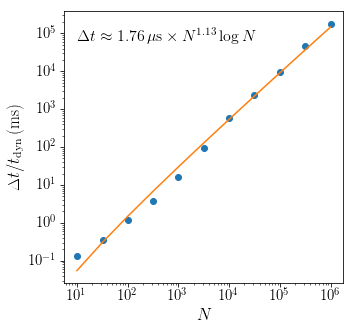

In [7]:
plot(Ns,numpy.nanmean(T,axis=1)*10.**3,'o')
p= numpy.polyfit(numpy.log(Ns),numpy.log(numpy.nanmean(T,axis=1)*10.**3/numpy.log(Ns)),deg=1)
plot(Ns,numpy.exp(numpy.polyval(p,numpy.log(Ns)))*numpy.log(Ns))
pyplot.text(10,10.**4.8,r'$\Delta t  \approx %.2f \,\mu\mathrm{s} \times N^{%.2f}\log N$' % 
            (numpy.exp(p[1])*10.**3.,p[0]),size=16.)
gca().set_xscale('log')
gca().set_yscale('log')
xlabel(r'$N$')
ylabel(r'$\Delta t / t_{\mathrm{dyn}}\,(\mathrm{ms})$')

However, with the same time step, energy is much better conserved for large $N$ than for small $N$:

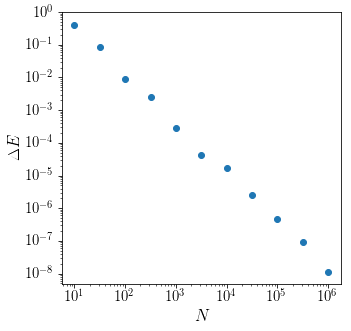

In [8]:
plot(Ns,numpy.nanmean(numpy.fabs(dE),axis=1)*10.**3,'o')
gca().set_xscale('log')
gca().set_yscale('log')
ylabel(r'$\Delta E$')
xlabel(r'$N$')

We can design the time step such that energy is conserved to about the same degree for different $N$:

In [9]:
Ns= numpy.round(10.**numpy.linspace(1.,6.,11)).astype('int')
ntrials= 3
T= numpy.empty((len(Ns),ntrials))
E= numpy.empty((len(Ns),ntrials))
dE= numpy.empty((len(Ns),ntrials))
tdyn_fac_norm= 10**4
for ii,N in enumerate(Ns):
    tnleap= int(numpy.ceil(((3000.*tdyn_fac_norm)/N)**1.))
    tdt= tdyn*(tdyn_fac_norm/N)**.15/10.
    for jj in range(ntrials):
        x,v,m,tdyn= initialize_selfgravitating_disk(N)
        E[ii,jj]= wendy.energy(x,v,m)
        g= wendy.nbody(x,v,m,tdt,approx=True,
                       nleap=tnleap,full_output=True)
        tx,tv, time_elapsed= next(g)
        T[ii,jj]= time_elapsed/tdt
        dE[ii,jj]= (E[ii,jj]-wendy.energy(tx,tv,m))/E[ii,jj]

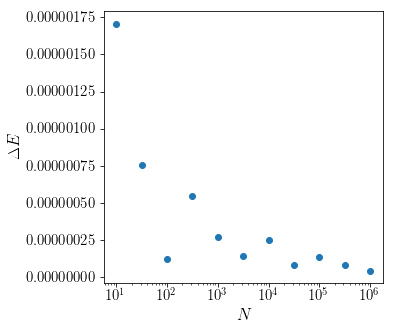

In [10]:
plot(Ns,numpy.nanmean(numpy.fabs(dE),axis=1)*10.**3,'o')
gca().set_xscale('log')
#gca().set_yscale('log')
ylabel(r'$\Delta E$')
xlabel(r'$N$')

In this case, the algorithm for integrating the self-gravitating $\mathrm{sech}^2$ disk scales much better, approximately as $N^{1/4}\log N$:

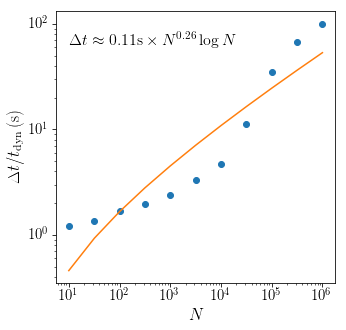

In [11]:
plot(Ns,numpy.nanmean(T,axis=1),'o')
p= numpy.polyfit(numpy.log(Ns),numpy.log(numpy.nanmean(T,axis=1)/numpy.log(Ns)),deg=1)
plot(Ns,numpy.exp(numpy.polyval(p,numpy.log(Ns)))*numpy.log(Ns))
pyplot.text(10,10.**1.8,r'$\Delta t  \approx %.2f \mathrm{s} \times N^{%.2f}\log N\,$' % 
            (numpy.exp(p[1]),p[0]),size=16.)
gca().set_xscale('log')
gca().set_yscale('log')
xlabel(r'$N$')
ylabel(r'$\Delta t / t_{\mathrm{dyn}}\,(\mathrm{s})$')